In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
df = pd.read_excel('/content/Emergency_Literacy.xlsx')

In [ ]:
!pip install streamlit pyngrok

In [ ]:
# Data Cleaning
df = df.drop(columns=["Name", "Email"])

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Month"] = df["Timestamp"].dt.month
df["Hour"] = df["Timestamp"].dt.hour

df.drop(columns=["Timestamp"], inplace=True)

In [ ]:
# EDA
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Age_Group                        1800 non-null   object
 1   Education_Level                  1800 non-null   object
 2   Occupation                       1800 non-null   object
 3   Area_Type                        1800 non-null   object
 4   Health_Literacy_Score            1800 non-null   int64 
 5   Understands_Doctor               1800 non-null   object
 6   Knows_Emergency_Numbers          1800 non-null   object
 7   Health_Info_Source               1800 non-null   object
 8   Aware_of_PreAlert                1800 non-null   object
 9   Received_Alert_Before            1800 non-null   object
 10  Preferred_Alert_Method           1800 non-null   object
 11  Faced_Emergency_Last5Yrs         1800 non-null   object
 12  Emergency_Response_Time          1

,Health_Literacy_Score,Emergency_Response_Satisfaction,Emergency_Confidence,Month,Hour
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.900000,2.840000,2.677778,9.133333,10.813333
std,1.413427,1.497435,1.498769,2.717780,6.827717
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,8.000000,5.000000
50%,3.000000,3.000000,2.000000,10.000000,10.000000
75%,4.000000,4.000000,4.000000,11.000000,16.000000
max,5.000000,5.000000,5.000000,12.000000,23.000000


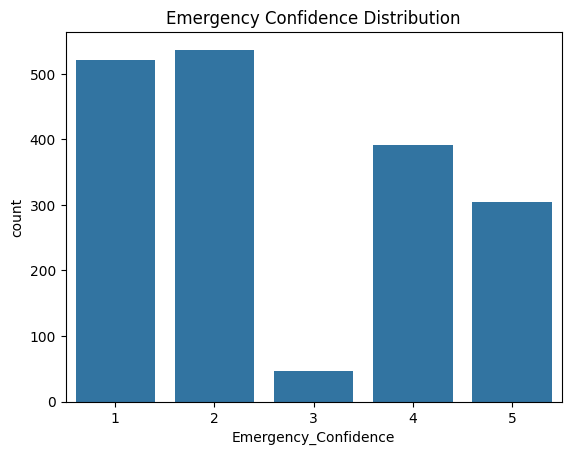

In [ ]:
# Target Distribution
sns.countplot(x="Emergency_Confidence", data=df)
plt.title("Emergency Confidence Distribution")
plt.show()

In [ ]:
df["Emergency_Confidence_Binary"] = df["Emergency_Confidence"].apply(lambda x: 0 if x <= 2 else 1)

In [ ]:
X = df.drop(columns=["Emergency_Confidence","Emergency_Confidence_Binary"])
y = df["Emergency_Confidence_Binary"]

In [ ]:
# Encoding Values
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Scaling Values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
# Model Creation
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Making Prediction
y_pred = model.predict(X_test)

In [ ]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9083333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       212
           1       0.93      0.84      0.88       148

    accuracy                           0.91       360
   macro avg       0.91      0.90      0.90       360
weighted avg       0.91      0.91      0.91       360



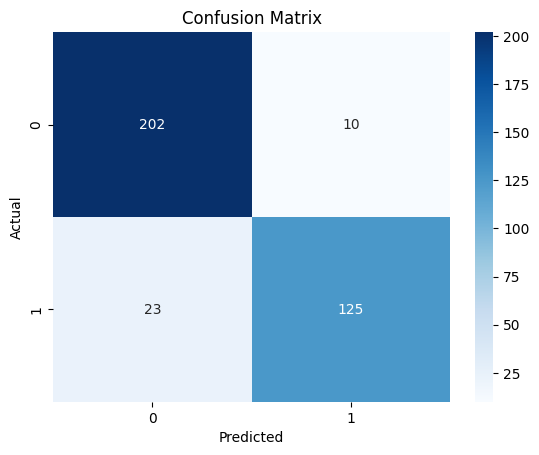

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

feature_importance.head(10)

,Feature,Coefficient
1,Emergency_Response_Satisfaction,1.266023
0,Health_Literacy_Score,1.188590
27,Aware_of_PreAlert_Yes,0.887444
39,Main_Barrier_Lack of awareness,0.361742
29,Preferred_Alert_Method_Phone Call,0.329935
43,Distance_to_Facility_>5 km,0.236611
38,Main_Barrier_Distance,0.234673
13,Occupation_Retired/Unemployed,0.188224
34,Emergency_Response_Time_<15 min,0.140114
41,Distance_to_Facility_3–5 km,0.138957


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=1100,
    max_depth=8,
    min_samples_split=10,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9138888888888889
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       212
           1       0.94      0.84      0.89       148

    accuracy                           0.91       360
   macro avg       0.92      0.90      0.91       360
weighted avg       0.92      0.91      0.91       360



In [ ]:
import joblib

joblib.dump(model, "emergency_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import pandas as pd


model = joblib.load("emergency_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("Community Emergency Readiness Predictor")
st.write("Enter key details to predict emergency preparedness")
expected_features = ['Health_Literacy_Score', 'Emergency_Response_Satisfaction', 'Month', 'Hour',
                     'Age_Group_26–35', 'Age_Group_36–45', 'Age_Group_46–60', 'Age_Group_60+',
                     'Education_Level_Higher secondary', 'Education_Level_No formal education', 'Education_Level_Postgraduate+', 'Education_Level_School level',
                     'Occupation_Homemaker', 'Occupation_Retired/Unemployed', 'Occupation_Self-employed', 'Occupation_Student',
                     'Area_Type_Semi-urban', 'Area_Type_Slum/High-density', 'Area_Type_Urban',
                     'Understands_Doctor_Often', 'Understands_Doctor_Rarely', 'Understands_Doctor_Sometimes',
                     'Knows_Emergency_Numbers_Yes',
                     'Health_Info_Source_Family/Friends', 'Health_Info_Source_Internet', 'Health_Info_Source_Social Media', 'Health_Info_Source_TV/Radio',
                     'Aware_of_PreAlert_Yes', 'Received_Alert_Before_Yes',
                     'Preferred_Alert_Method_Phone Call', 'Preferred_Alert_Method_SMS', 'Preferred_Alert_Method_Siren/Loudspeaker',
                     'Faced_Emergency_Last5Yrs_Yes',
                     'Emergency_Response_Time_30–60 min', 'Emergency_Response_Time_<15 min', 'Emergency_Response_Time_>1 hour',
                     'Nearby_Healthcare_Available_Yes',
                     'Main_Barrier_Cost', 'Main_Barrier_Distance', 'Main_Barrier_Lack of awareness', 'Main_Barrier_Traffic',
                     'Distance_to_Facility_3–5 km', 'Distance_to_Facility_<1 km', 'Distance_to_Facility_>5 km']

input_dict = {feature: 0 for feature in expected_features}

input_dict['Month'] = 9
input_dict['Hour'] = 11

# Inputs
health_literacy = st.slider("1. Self-rated understanding of basic health information (1-5)", 1, 5, 3)
emergency_satisfaction = st.slider("2. Emergency Response Satisfaction (1-5)", 1, 5, 3)
pre_alert = st.selectbox("3. Aware of Pre-alert Systems", ["No", "Yes"])
distance = st.selectbox("4. Distance to Nearest Healthcare Facility", ["1–3 km", "<1 km", "3–5 km", ">5 km"])

occupation = st.selectbox(
    "5. Occupation",
    ["Employed", "Homemaker", "Retired/Unemployed", "Self-employed", "Student"]
)
main_barrier = st.selectbox(
    "6. Main Barrier to Emergency Care",
    ["No barrier", "Cost", "Distance", "Lack of awareness", "Traffic"]
)
preferred_alert_method = st.selectbox(
    "7. Preferred Alert Method",
    ["Email", "Phone Call", "SMS", "Siren/Loudspeaker", "Other"]
)
emergency_response_time = st.selectbox(
    "8. Typical Emergency Response Time",
    ["15–30 min", "<15 min", "30–60 min", ">1 hour"]
)

# Update input_dict with user's selections
input_dict['Health_Literacy_Score'] = health_literacy
input_dict['Emergency_Response_Satisfaction'] = emergency_satisfaction
input_dict['Aware_of_PreAlert_Yes'] = 1 if pre_alert == "Yes" else 0

# Distance_to_Facility:
if distance == "<1 km":
    input_dict['Distance_to_Facility_<1 km'] = 1
elif distance == "3–5 km":
    input_dict['Distance_to_Facility_3–5 km'] = 1
elif distance == ">5 km":
    input_dict['Distance_to_Facility_>5 km'] = 1

# Occupation:
if occupation == "Homemaker":
    input_dict['Occupation_Homemaker'] = 1
elif occupation == "Retired/Unemployed":
    input_dict['Occupation_Retired/Unemployed'] = 1
elif occupation == "Self-employed":
    input_dict['Occupation_Self-employed'] = 1
elif occupation == "Student":
    input_dict['Occupation_Student'] = 1

# Main_Barrier:
if main_barrier == "Cost":
    input_dict['Main_Barrier_Cost'] = 1
elif main_barrier == "Distance":
    input_dict['Main_Barrier_Distance'] = 1
elif main_barrier == "Lack of awareness":
    input_dict['Main_Barrier_Lack of awareness'] = 1
elif main_barrier == "Traffic":
    input_dict['Main_Barrier_Traffic'] = 1

# Preferred_Alert_Method:
if preferred_alert_method == "Phone Call":
    input_dict['Preferred_Alert_Method_Phone Call'] = 1
elif preferred_alert_method == "SMS":
    input_dict['Preferred_Alert_Method_SMS'] = 1
elif preferred_alert_method == "Siren/Loudspeaker":
    input_dict['Preferred_Alert_Method_Siren/Loudspeaker'] = 1

# Emergency_Response_Time:
if emergency_response_time == "<15 min":
    input_dict['Emergency_Response_Time_<15 min'] = 1
elif emergency_response_time == "30–60 min":
    input_dict['Emergency_Response_Time_30–60 min'] = 1
elif emergency_response_time == ">1 hour":
    input_dict['Emergency_Response_Time_>1 hour'] = 1


input_df = pd.DataFrame([input_dict], columns=expected_features)

input_scaled = scaler.transform(input_df)

if st.button("Predict"):
    prediction = model.predict(input_scaled)[0]
    st.success("High Emergency Readiness" if prediction == 1 else "Low Emergency Readiness")


Overwriting app.py


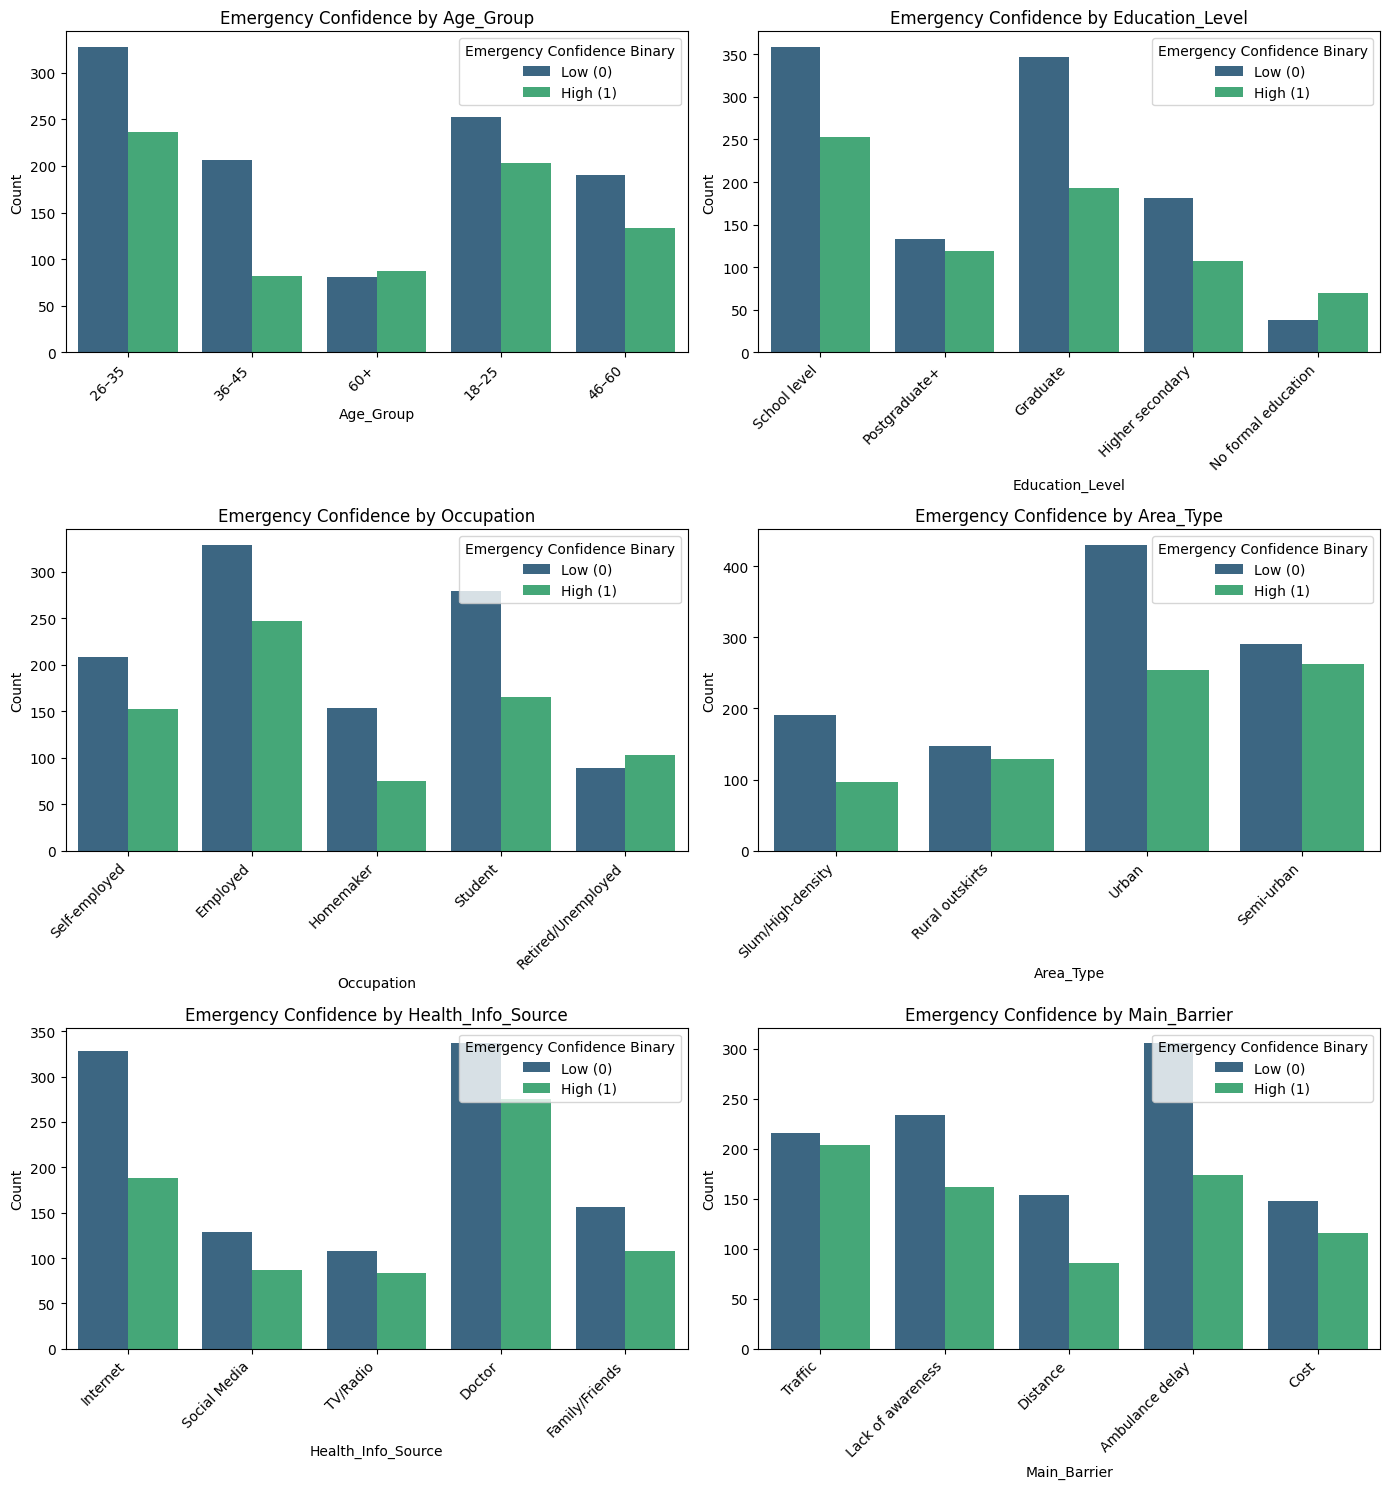

In [ ]:
key_categorical_features = [
    'Age_Group', 'Education_Level', 'Occupation', 'Area_Type',
    'Health_Info_Source', 'Main_Barrier'
]

num_features = len(key_categorical_features)
num_cols = 2 # Display plots in 2 columns
num_rows = (num_features + num_cols - 1) // num_cols # Calculate rows needed

plt.figure(figsize=(num_cols * 7, num_rows * 5))

for i, col in enumerate(key_categorical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(x=col, hue='Emergency_Confidence_Binary', data=df, palette='viridis')
    plt.title(f'Emergency Confidence by {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Emergency Confidence Binary', labels=['Low (0)', 'High (1)'], loc='upper right')

plt.tight_layout()
plt.show()